<a href="https://colab.research.google.com/github/ozzmanmuhammad/Synthetic-Images-generation-with-DCGANs/blob/main/DCGAN_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align=center>Generate Synthetic Images with DCGANs in Tensorflow</h2>
<h4>Paper:<a href='https://arxiv.org/abs/1511.06434'>Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).<a/></h4>

## Task 1: Project Overview and Import Libraries

In [2]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.9.2


## Task 2: Load and Preprocess the Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

4422102/4422102 [==============================] - 0s 0us/step


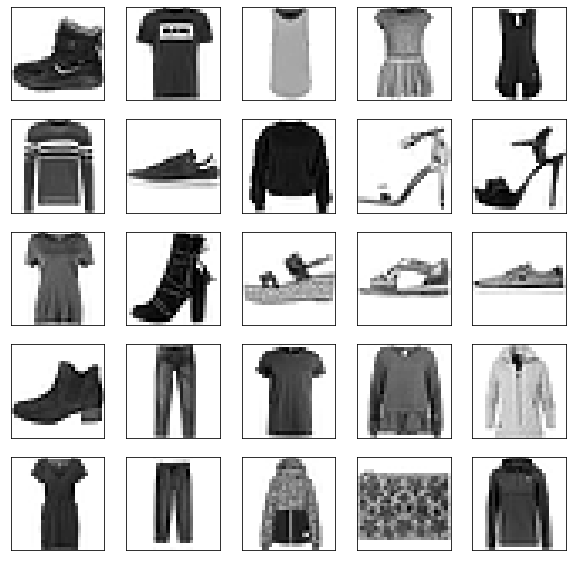

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary)
plt.show()

## Task 3: Create Batches of Training Data

In [15]:
BATCH_SIZE = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

## Task 4: Build the Generator Network for DCGAN

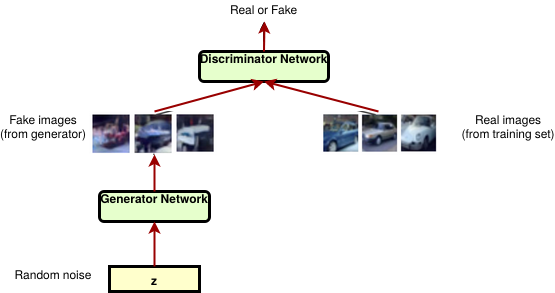

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture guidelines for stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

In [5]:
num_features = 100

generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(7 * 7  * 256, input_shape = [num_features]),
    tf.keras.layers.Reshape([7, 7, 256]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(128, (5,5), (2,2), padding='same', activation='selu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding='same', activation='selu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding='same', activation='tanh'),
])


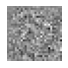

In [6]:
noise = tf.random.normal(shape=[1, num_features])
generated_image = generator(noise, training=False)
plot_utils.show(generated_image, 1)

## Task 5: Build the Discriminator Network for DCGAN

In [7]:
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[28, 28, 1]),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(256, (5,5), (2,2), padding="same"),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (5,5), (1,1), padding="same"),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
    
])

In [8]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49849558]], shape=(1, 1), dtype=float32)


## Task 6: Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [9]:
discriminator.compile(loss='binary_crossentropy', optimizer = 'rmsprop')
discriminator.trainable = False
Gan = tf.keras.models.Sequential([generator, discriminator])
Gan.compile(loss='binary_crossentropy', optimizer = 'rmsprop')

## Task 7: Define Training Procedure

In [18]:
seed = tf.random.normal(shape=[BATCH_SIZE, 100])

In [19]:
def train_DCGAN(gan, dataset, batch_size, num_features, epochs = 5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print(f'Epochs {epoch + 1}/{epochs}')
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
            y1 = tf.constant([[0.]]*batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            y2 = tf.constant([[1.]]*batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [20]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Task 8: Train DCGAN

In [21]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. -1.

In [22]:
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

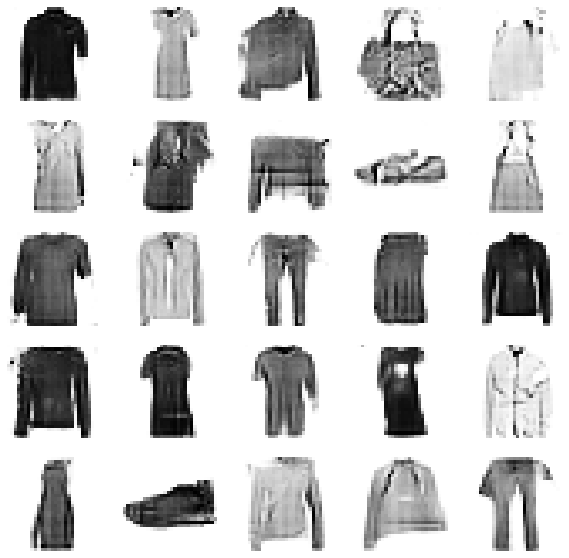

CPU times: user 35min 11s, sys: 1min 37s, total: 36min 48s
Wall time: 35min 11s


In [23]:
%%time
train_DCGAN(Gan, dataset, BATCH_SIZE, num_features, epochs=50)

## Task 9: Generate Synthetic Images with DCGAN

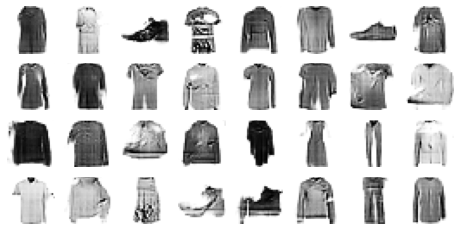

In [24]:
noise = tf.random.normal(shape=[BATCH_SIZE, num_features])
generated_image = generator(noise)
plot_utils.show(generated_image, 8)

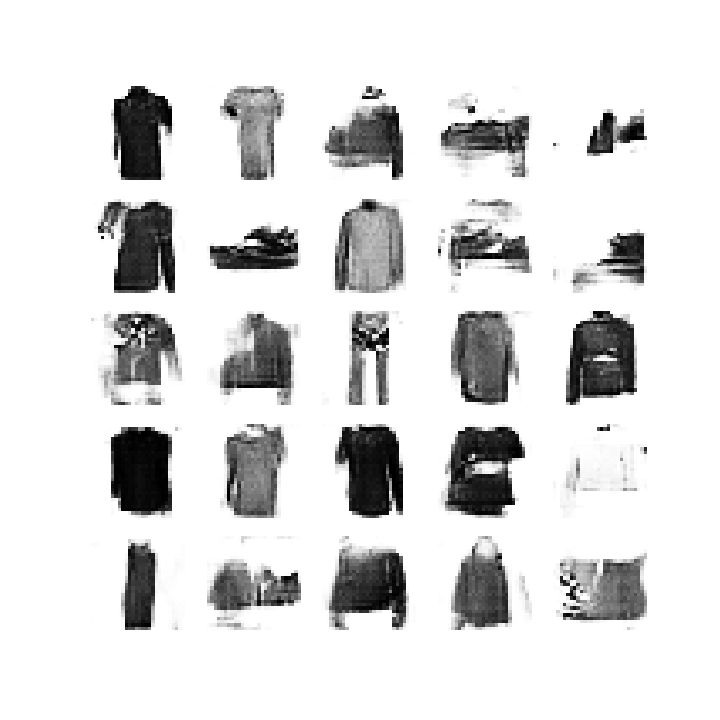

In [25]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)